# 5.7 Covid

Nuestro objetivo es crear un modelo para determinar el numero de casos de Covid que puden haber la proxima semana.

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

import xgboost as xgb

In [2]:
# Unlimit pandas display
pd.set_option('display.max_rows', None)

## ETL

In [3]:
# Cargamos los datos

original = pd.read_csv('data/5.7.covid data.csv', sep = ',', header = 0)

In [4]:
# Cambiamos el tipo de la columna fecha de string a datetime
original['date']= pd.to_datetime(original['date'])

# Ponemos la fecha como inidice
original = original.set_index('date')

In [5]:
original.tail()

,cases,deaths
date,,
2021-04-02,30631753,553554
2021-04-03,30695580,554302
2021-04-04,30732273,554579
2021-04-05,30808897,555109
2021-04-06,30870922,556016


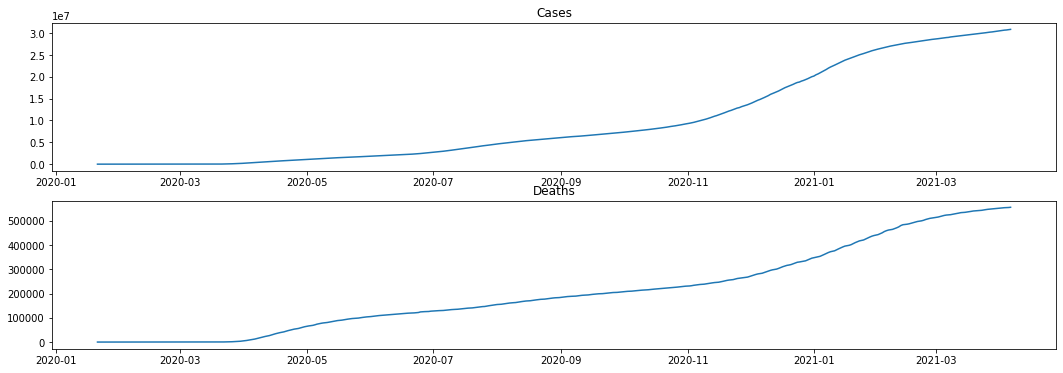

In [6]:
# Pintamos la serie

# Generamos un subplot para los dos graficos
axis = plt.figure(figsize=(18, 6)).subplots(2)

# Casos
axis[0].plot(original['cases'])
axis[0].set_title("Cases")
  
# For Cosine Function
axis[1].plot(original['deaths'])
axis[1].set_title("Deaths")

plt.show()

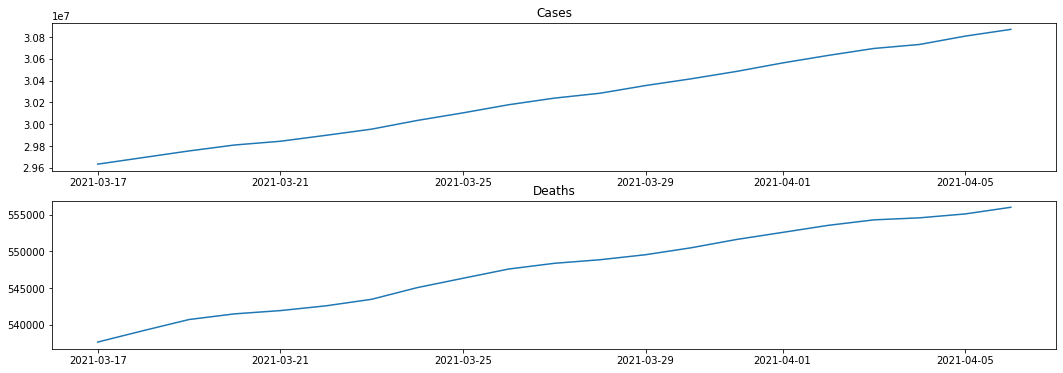

In [7]:
# Pintamos la serie

# Generamos un subplot para los dos graficos
axis = plt.figure(figsize=(18, 6)).subplots(2)

# Casos
axis[0].plot(original['cases'].tail(21))
axis[0].set_title("Cases")
  
# For Cosine Function
axis[1].plot(original['deaths'].tail(21))
axis[1].set_title("Deaths")

plt.show()

No se muestra una estacionalidad aparente. Si nos fijamos en las ultimas 3 semanas de datos la grafica de casos parece casi lineal.

Como los datos son sobre el total acumulado de casos vamos a pasarlos a casos diarios a ver si vemos algo mas.

In [8]:
# Create a copy of the original data frame
df = original.copy()

df['cases'] = pd.Series(df['cases']).diff()
df['deaths'] = pd.Series(df['deaths']).diff()

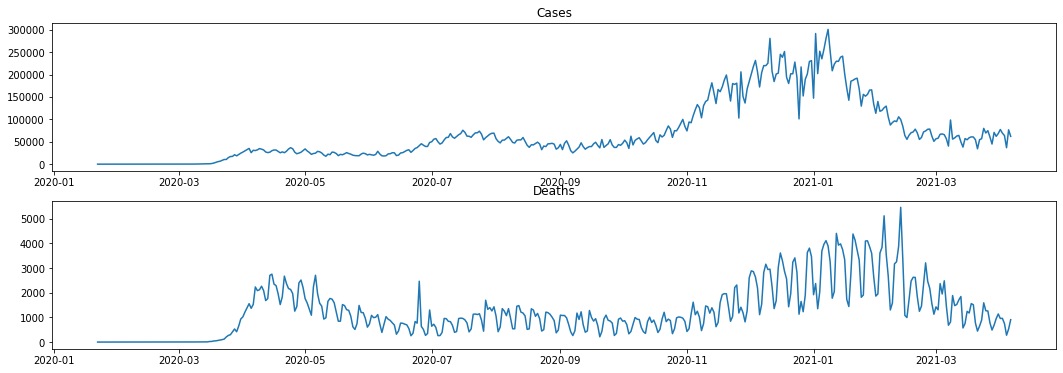

In [9]:
# Pintamos la serie

# Generamos un subplot para los dos graficos
axis = plt.figure(figsize=(18, 6)).subplots(2)

# Casos
axis[0].plot(df['cases'])
axis[0].set_title("Cases")
  
# For Cosine Function
axis[1].plot(df['deaths'])
axis[1].set_title("Deaths")

plt.show()

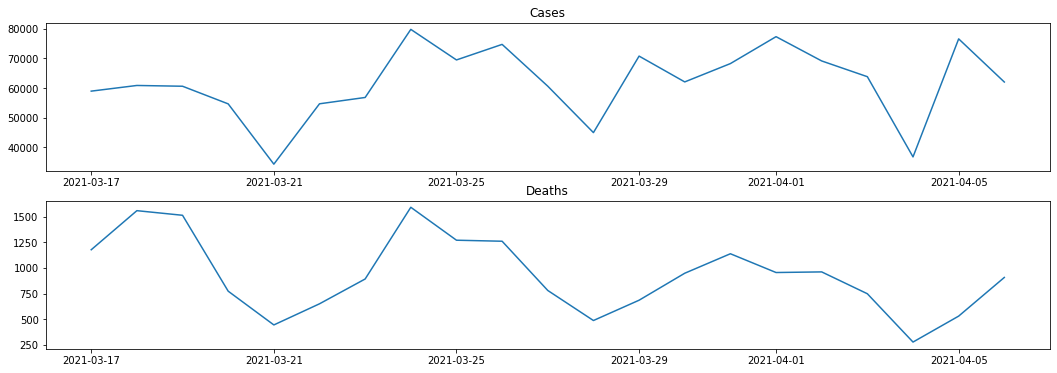

In [10]:
# Pintamos la serie

# Generamos un subplot para los dos graficos
axis = plt.figure(figsize=(18, 6)).subplots(2)

# Casos
axis[0].plot(df['cases'].tail(21))
axis[0].set_title("Cases")
  
# For Cosine Function
axis[1].plot(df['deaths'].tail(21))
axis[1].set_title("Deaths")

plt.show()

Con esta transformacion ya vemos cierta estacionalidad, pero sigue habiendo tendencia.

Vamos a descartar el uso de ARIMA ya que necesitariamos un tratamiento muy grande de los datos y aun asi no nos garantiza que lleguemos a una serie suficientemente buena.

La estacionalidad que se muestra en las 3 ultimas semanas nos indica que hay menos casos los domingos, seguramente porque la recogida de datos es menor al ser festivo.

In [11]:
# Separmos los datos de testeo
target_test = pd.Series(df['2021-03-01':]['cases'])

## Modelo Naive

In [12]:
# datos a validar con predicción de método naive
# la predicción será el valor anterior
naive_forecast = pd.Series(df['2021-02-28':]['cases']).shift(1)[1:]

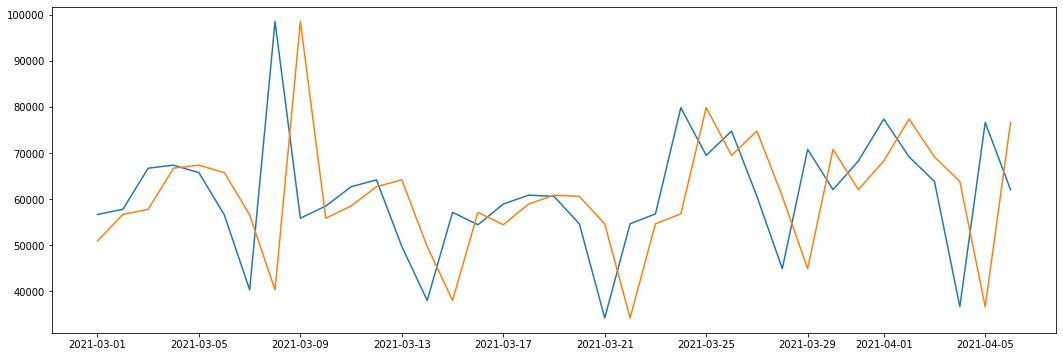

In [13]:
# Pintamos la serie

plt.figure(figsize=(18, 6))
plt.plot(target_test)
plt.plot(naive_forecast)

In [14]:
#Cálculo del error
print('Error mse: ', mean_squared_error(target_test, naive_forecast))
print('Error mae: ', mean_absolute_error(target_test, naive_forecast))

Error mse:  322464372.7837838
Error mae:  12697.216216216217


Los errores son muy grandes en magnitud pero esto es debido a que los datos tambien lo son.

Vamos a usar este metodo como referencia para los siguientes, asi sabremos si podemos mejorar la intuición más basica.

## Modelo Random Forest Regressor

In [15]:
def extended_data(data_frame, window_size = 7, step_size = 1, horizon = 1):
    for i in range(1, window_size + 1):
        data_frame['cases-' + str(i)] = df['cases'].shift(i + horizon - 1)
        data_frame['deaths-' + str(i)] = df['deaths'].shift(i + horizon - 1)
    return data_frame

In [16]:
data = extended_data(df.copy(), window_size = 7, horizon = 1)
data.tail(10)

,cases,deaths,cases-1,deaths-1,cases-2,deaths-2,cases-3,deaths-3,cases-4,deaths-4,cases-5,deaths-5,cases-6,deaths-6,cases-7,deaths-7
date,,,,,,,,,,,,,,,,
2021-03-28,44910.0,487.0,60614.0,780.0,74756.0,1260.0,69494.0,1270.0,79835.0,1591.0,56799.0,892.0,54658.0,650.0,34237.0,444.0
2021-03-29,70794.0,685.0,44910.0,487.0,60614.0,780.0,74756.0,1260.0,69494.0,1270.0,79835.0,1591.0,56799.0,892.0,54658.0,650.0
2021-03-30,62061.0,948.0,70794.0,685.0,44910.0,487.0,60614.0,780.0,74756.0,1260.0,69494.0,1270.0,79835.0,1591.0,56799.0,892.0
2021-03-31,68262.0,1138.0,62061.0,948.0,70794.0,685.0,44910.0,487.0,60614.0,780.0,74756.0,1260.0,69494.0,1270.0,79835.0,1591.0
2021-04-01,77369.0,955.0,68262.0,1138.0,62061.0,948.0,70794.0,685.0,44910.0,487.0,60614.0,780.0,74756.0,1260.0,69494.0,1270.0
2021-04-02,69152.0,961.0,77369.0,955.0,68262.0,1138.0,62061.0,948.0,70794.0,685.0,44910.0,487.0,60614.0,780.0,74756.0,1260.0
2021-04-03,63827.0,748.0,69152.0,961.0,77369.0,955.0,68262.0,1138.0,62061.0,948.0,70794.0,685.0,44910.0,487.0,60614.0,780.0
2021-04-04,36693.0,277.0,63827.0,748.0,69152.0,961.0,77369.0,955.0,68262.0,1138.0,62061.0,948.0,70794.0,685.0,44910.0,487.0
2021-04-05,76624.0,530.0,36693.0,277.0,63827.0,748.0,69152.0,961.0,77369.0,955.0,68262.0,1138.0,62061.0,948.0,70794.0,685.0


<AxesSubplot:>

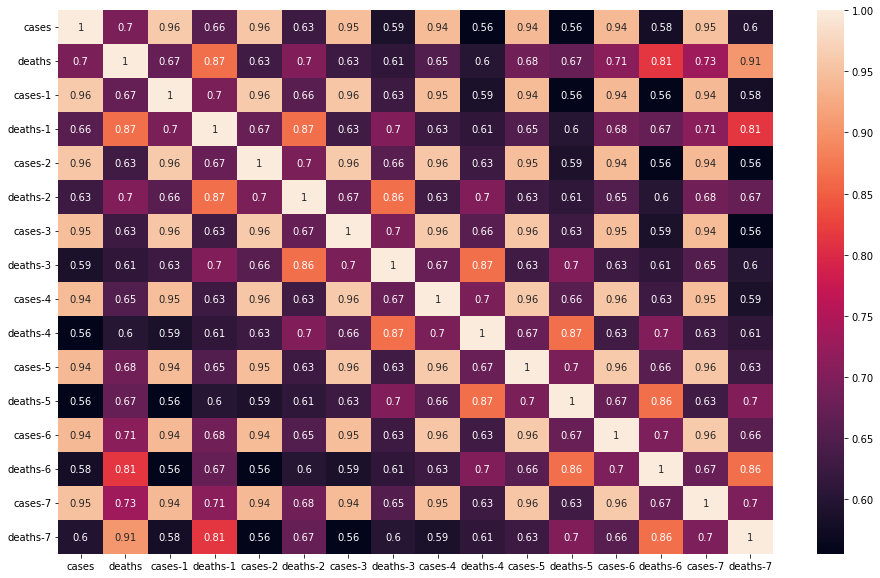

In [17]:
# Pintamos la matrix de correlacion

plt.figure(figsize = (16, 10))
sns.heatmap(data.corr(), annot = True)

La correlacion entre los casos y las muertes no es muy alto, pero la autocorrelacion es alta sobretodo con los casos. Asi que podemos dejar los datos de muertes para entrenar si problema.

In [18]:
# Generamos el train data sin los registros con nulos ni los registros de test
X_train_1 = data[8:-len(target_test)]
y_train_1 = X_train_1[['cases', 'deaths']]
X_train_1 = X_train_1.drop(columns = ['cases', 'deaths'])

# Generamos el test data
X_test_1 = data[-len(target_test):]
y_test_1 = X_test_1[['cases', 'deaths']]
X_test_1 = X_test_1.drop(columns = ['cases', 'deaths'])

In [19]:
# Creamos y entrenamos el modelo
rfr = RandomForestRegressor(random_state=0).fit(X_train_1, y_train_1)

In [20]:
# Hacemos una prediccion con los datos de test, usamos los datos reales y los los predichos para cada dia de testeo 
rfr_forecast = pd.DataFrame(rfr.predict(X_test_1), columns=['cases', 'deaths'])

# Añadimos la fecha a las predicciones y la ponemos como indice
rfr_forecast['date'] = pd.date_range(start='2021-03-01', end='2021-04-06')
rfr_forecast = rfr_forecast.set_index('date')

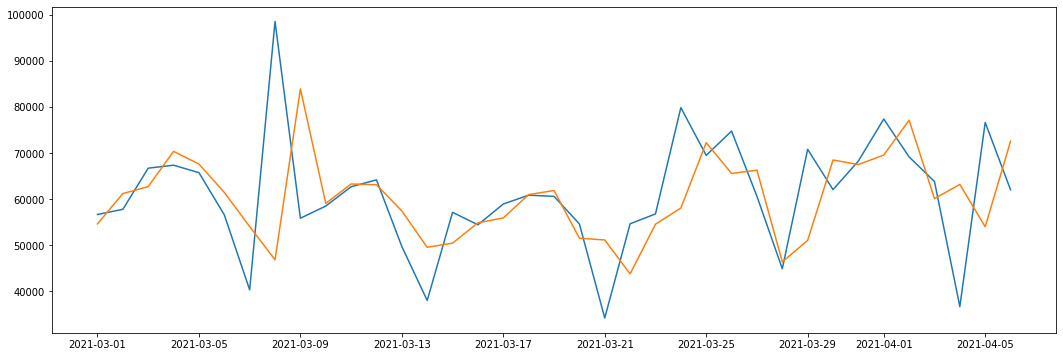

In [21]:
# Pintamos la serie

plt.figure(figsize=(18, 6))
plt.plot(target_test)
plt.plot(rfr_forecast['cases'])

In [22]:
#Cálculo del error
print('Error mse: ', mean_squared_error(target_test, rfr_forecast['cases']))
print('Error mae: ', mean_absolute_error(target_test, rfr_forecast['cases']))

Error mse:  185807087.1052162
Error mae:  8800.875135135135


Ahora hacemos las predicciones usando los datos que predice el modelo para los dias que dependan de otros dias que ya hemos predicho.

In [46]:
def new_line(data, new, n):
    data = np.array(data)
    for i in range(len(data[0]) - n):
        data[0][i] = data[0][i + n]
    for j in range(n):
        if n > 1:
            data[0][len(data[0]) - n + j] = new[0][j]
        else:
            data[0][len(data[0]) - n + j] = new[0]
    
    return data

def make_predictions(model, initial_data, curr_day, last_day, pred_col):
    X_pred = initial_data
    cols = X_pred.columns
    forecast = pd.DataFrame()
    while curr_day <= last_day:
        pred = model.predict(X_pred[-1:])
        forecast = forecast.append(pd.DataFrame(pred, columns = pred_col, index = [curr_day]))
        
        curr_day = curr_day + pd.DateOffset(1)
        X_pred = X_pred.append(pd.DataFrame(new_line(X_pred[-1:], pred, len(pred_col)), columns = cols, index = [curr_day]))
    
    return forecast

In [47]:
rfr_dynamic_forecast = make_predictions(rfr, X_test_1[:1], pd.to_datetime('2021-03-01'), pd.to_datetime('2021-04-06'), ['cases', 'deaths'])

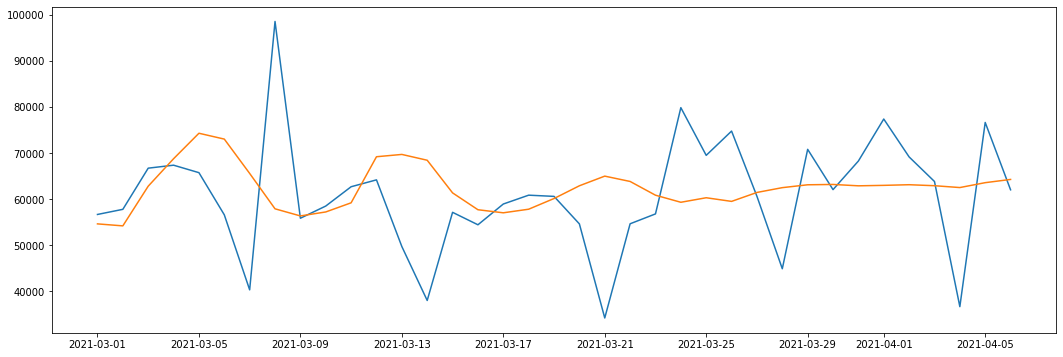

In [48]:
# Pintamos la serie

plt.figure(figsize=(18, 6))
plt.plot(target_test)
plt.plot(rfr_dynamic_forecast['cases'])

In [49]:
#Cálculo del error
print('Error mse: ', mean_squared_error(target_test, rfr_dynamic_forecast['cases']))
print('Error mae: ', mean_absolute_error(target_test, rfr_dynamic_forecast['cases']))

Error mse:  200114754.41414598
Error mae:  9932.985945945944


## Modelo XGBoost

Para usar XGBoost vamos a usar solo los datos de los casos ya que no podemos hacer regressiones multivariables.

In [50]:
def extended_cases(data_frame, window_size = 7, step_size = 1, horizon = 1):
    data_frame = data_frame.drop(columns = ['deaths'])
    for i in range(1, window_size + 1):
        data_frame['cases-' + str(i)] = df['cases'].shift(i + horizon - 1)
    return data_frame

In [51]:
case_data = extended_cases(df.copy(), window_size = 7, horizon = 1)
case_data.head(10)

,cases,cases-1,cases-2,cases-3,cases-4,cases-5,cases-6,cases-7
date,,,,,,,,
2020-01-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-22,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-23,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-24,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
2020-01-25,1.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN
2020-01-26,2.0,1.0,1.0,0.0,0.0,NaN,NaN,NaN
2020-01-27,0.0,2.0,1.0,1.0,0.0,0.0,NaN,NaN
2020-01-28,0.0,0.0,2.0,1.0,1.0,0.0,0.0,NaN
2020-01-29,0.0,0.0,0.0,2.0,1.0,1.0,0.0,0.0


In [52]:
# Generamos el train data sin los registros con nulos ni los registros de test
X_train_2 = case_data[8:-len(target_test)]
y_train_2 = X_train_2['cases']
X_train_2 = X_train_2.drop(columns = ['cases'])

# Generamos el test data
X_test_2 = case_data[-len(target_test):]
y_test_2 = X_test_2['cases']
X_test_2 = X_test_2.drop(columns = ['cases'])

In [53]:
# Creamos y entrenamos el modelo
gbr = GradientBoostingRegressor(n_estimators=40, random_state=1, verbose=1).fit(X_train_2, y_train_2)

      Iter       Train Loss   Remaining Time 
         1  4039104498.3086            0.12s
         2  3321722543.1178            0.10s
         3  2737003014.1286            0.09s
         4  2263228169.3357            0.08s
         5  1875088740.4584            0.08s
         6  1560088425.7895            0.08s
         7  1302656502.9009            0.08s
         8  1087918504.9780            0.07s
         9   914454144.4766            0.07s
        10   771402567.2623            0.06s
        20   207593852.5281            0.03s
        30   113929657.8388            0.01s
        40    83506839.1219            0.00s


In [54]:
# Hacemos una prediccion con los datos de test, usamos los datos reales y los los predichos para cada dia de testeo 
gbr_forecast = pd.DataFrame(gbr.predict(X_test_2), columns = ['cases'])

# Añadimos la fecha a las predicciones y la ponemos como indice
gbr_forecast['date'] = pd.date_range(start='2021-03-01', end='2021-04-06')
gbr_forecast = gbr_forecast.set_index('date')

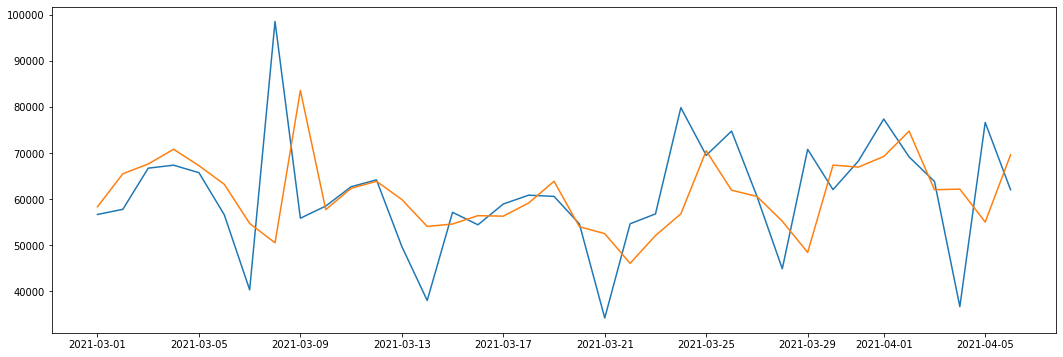

In [55]:
# Pintamos la serie

plt.figure(figsize=(18, 6))
plt.plot(target_test)
plt.plot(gbr_forecast)

In [56]:
#Cálculo del error
print('Error mse: ', mean_squared_error(target_test, gbr_forecast))
print('Error mae: ', mean_absolute_error(target_test, gbr_forecast))

Error mse:  184461955.0108172
Error mae:  8923.031182335893


In [57]:
gbr_dynamic_forecast = make_predictions(gbr, X_test_2[:1], pd.to_datetime('2021-03-01'), pd.to_datetime('2021-04-06'), ['cases'])

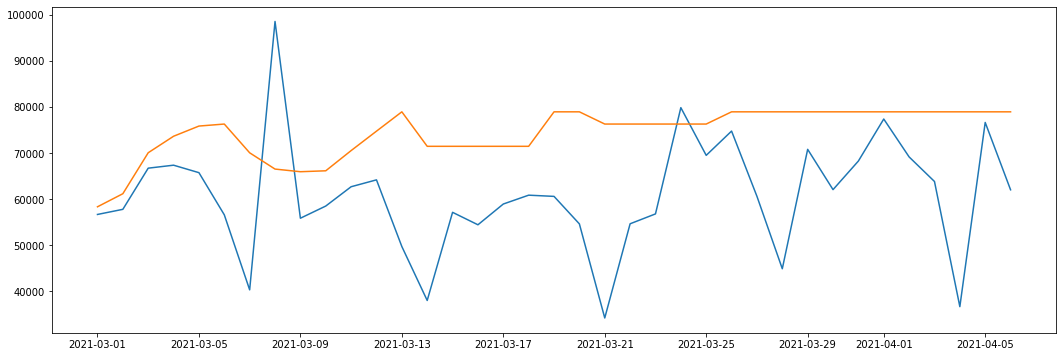

In [59]:
# Pintamos la serie

plt.figure(figsize=(18, 6))
plt.plot(target_test)
plt.plot(gbr_dynamic_forecast['cases'])

In [60]:
#Cálculo del error
print('Error mse: ', mean_squared_error(target_test, gbr_dynamic_forecast['cases']))
print('Error mae: ', mean_absolute_error(target_test, gbr_dynamic_forecast['cases']))

Error mse:  364902985.53191775
Error mae:  15553.820283527395


## Modelo Random Forest Regressor con Horizons